# Code cell 1:

In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)
print("Is CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch Version: 1.10.2+cu113
CUDA Version: 11.3
Is CUDA Available: True
GPU Name: GeForce GTX 1080
Using device: cuda


# Code cell 2:

In [8]:
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class WeatherDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        class_mapping = {'Cloudy': 0, 'Sunrise': 1, 'Shine': 2, 'Rain': 3}
        
        for class_name, label in class_mapping.items():
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for image_name in os.listdir(class_dir):
                    if image_name.lower().endswith('.jpg'):
                        image_path = os.path.join(class_dir, image_name)
                        self.data.append(image_path)
                        self.labels.append(label)
            else:
                print(f"Warning: Class directory '{class_dir}' is missing!")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        class_mapping = {'cloudy': 0, 'sunrise': 1, 'shine': 2, 'rain': 3}

        for image_name in os.listdir(root_dir):
            if image_name.lower().endswith('.jpg'):
                for class_name, label in class_mapping.items():
                    if image_name.lower().startswith(class_name):
                        image_path = os.path.join(root_dir, image_name)
                        self.data.append(image_path)
                        self.labels.append(label)
                        break
                else:
                    raise ValueError(f"Unknown label in filename: {image_name}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


train_dir = './'
test_dir = './Test'

train_dataset = WeatherDataset(train_dir, transform=transform)
test_dataset = TestDataset(test_dir, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ['cloudy', 'sunrise', 'shine', 'rain']
print(f"Classes: {classes}")


Classes: ['cloudy', 'sunrise', 'shine', 'rain']


# Code cell 3:

In [9]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, len(classes))
)
model = model.to(device)
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Code cell 4:

In [10]:
class MyLossFunction(nn.Module):
    def __init__(self, smoothing=0.1, num_classes=4, weight=None):
        super(MyLossFunction, self).__init__()
        self.smoothing = smoothing
        self.num_classes = num_classes
        self.weight = weight

    def forward(self, predictions, targets):
        assert targets.min() >= 0 and targets.max() < self.num_classes, \
            f"Targets should be in range [0, {self.num_classes - 1}], but found {targets}"
        print(f"Predictions shape: {predictions.shape}")
        print(f"Targets shape: {targets.shape}")

        targets_one_hot = torch.zeros_like(predictions).scatter_(1, targets.unsqueeze(1), 1)
        smooth_targets = (1 - self.smoothing) * targets_one_hot + self.smoothing / self.num_classes
        loss = -smooth_targets * torch.log_softmax(predictions, dim=1)
        if self.weight is not None:
            loss *= self.weight[targets].unsqueeze(1)
        return loss.sum(dim=1).mean()

class_weights = torch.tensor([1.0, 1.5, 1.2, 1.3], device=device)  # Example weights
criterion = MyLossFunction(smoothing=0.1, num_classes=len(classes), weight=class_weights)


# Code cell 5:

In [11]:
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=25)

# Code cell 6:

In [12]:
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.view(-1)  # Ensure labels are 1D

            optimizer.zero_grad()
            with autocast():
                outputs = model(inputs)
                print(f"Outputs shape: {outputs.shape}, Labels shape: {labels.shape}")  # Debug
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.view(-1)  # Ensure labels are 1D
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct / total)

        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
              f"Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25
)


Outputs shape: torch.Size([16, 4]), Labels shape: torch.Size([16])
Predictions shape: torch.Size([16, 4])
Targets shape: torch.Size([16])
Outputs shape: torch.Size([16, 4]), Labels shape: torch.Size([16])
Predictions shape: torch.Size([16, 4])
Targets shape: torch.Size([16])
Outputs shape: torch.Size([16, 4]), Labels shape: torch.Size([16])
Predictions shape: torch.Size([16, 4])
Targets shape: torch.Size([16])
Outputs shape: torch.Size([16, 4]), Labels shape: torch.Size([16])
Predictions shape: torch.Size([16, 4])
Targets shape: torch.Size([16])
Outputs shape: torch.Size([16, 4]), Labels shape: torch.Size([16])
Predictions shape: torch.Size([16, 4])
Targets shape: torch.Size([16])
Outputs shape: torch.Size([16, 4]), Labels shape: torch.Size([16])
Predictions shape: torch.Size([16, 4])
Targets shape: torch.Size([16])
Outputs shape: torch.Size([16, 4]), Labels shape: torch.Size([16])
Predictions shape: torch.Size([16, 4])
Targets shape: torch.Size([16])
Outputs shape: torch.Size([16, 4])

# Code cell 7:

Test Accuracy: 98.33%


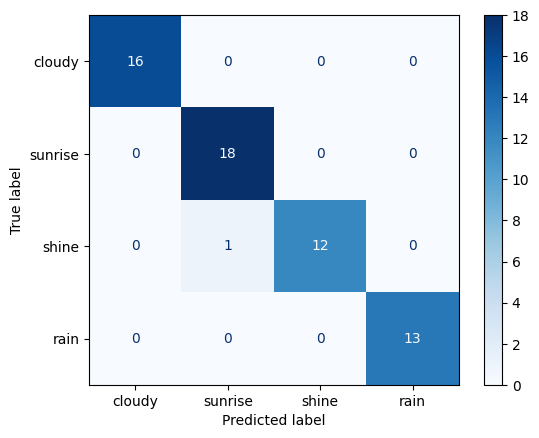

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Test Accuracy: {acc * 100:.2f}%")
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(cmap="Blues")
    plt.show()

    return acc, cm

test_acc, test_cm = evaluate_model(model, test_loader)

# Code cell 8:

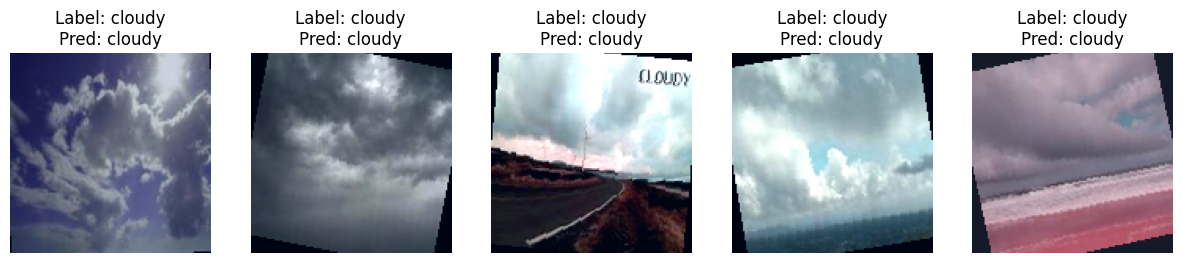

In [14]:
import random

def show_predictions(model, test_loader, classes, num_images=5):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        idx = random.randint(0, len(images) - 1)
        img = images[idx].cpu().numpy().transpose((1, 2, 0))
        img = np.clip(img * 0.229 + 0.485, 0, 1)
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {classes[labels[idx]]}\nPred: {classes[preds[idx]]}")
        axes[i].axis("off")
    plt.show()

show_predictions(model, test_loader, classes, num_images=5)

# Code cell 9:

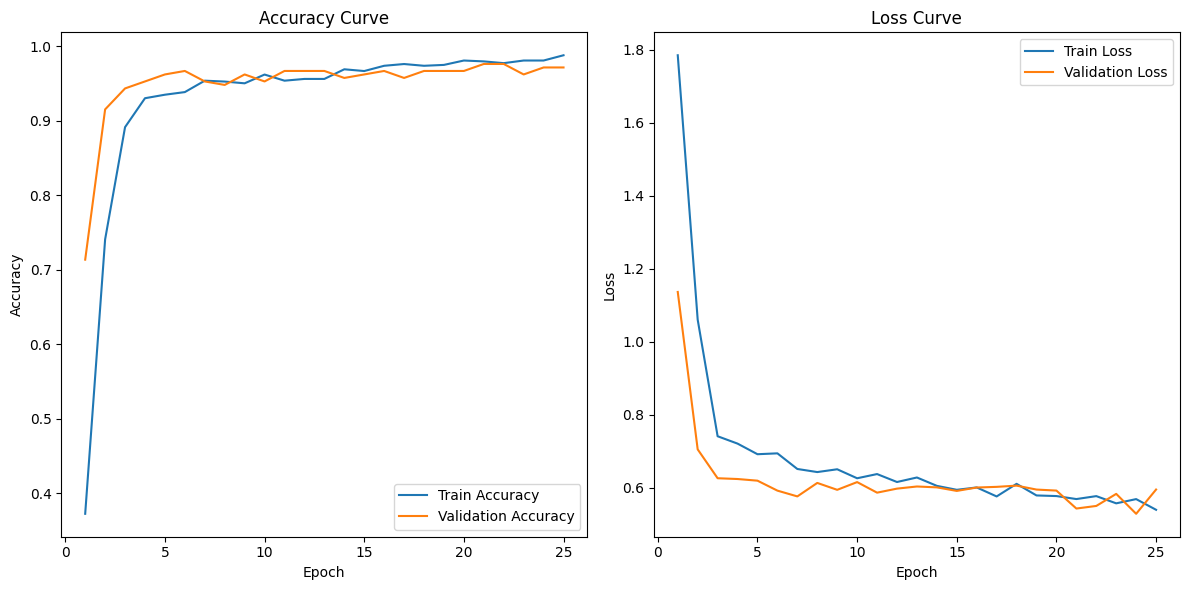

In [15]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.tight_layout()
plt.show()
